<a href="https://colab.research.google.com/github/yeoun9/torchpm/blob/main/examples/nmw_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/yeoun9/torchpm.git
import torchpm as tcpm
import torch as tc
import numpy as np
import matplotlib.pyplot as plt

# Model Building

In [17]:
dataset_file_path = 'https://raw.githubusercontent.com/yeoun9/torchpm/main/examples/THEO.csv'
column_names = ['ID', 'AMT', 'TIME',    'DV',   'BWT', 'CMT', "MDV", "tmpcov", "RATE"]

device = tc.device("cuda:0" if tc.cuda.is_available() else "cpu")
dataset = tcpm.data.CSVDataset(dataset_file_path, column_names, device)

class PKParameter(tcpm.funcgen.PKParameterGenerator) :
    def __call__(self, theta, eta) :
        k_a = theta[0]*tc.exp(eta[0])
        v = theta[1]*tc.exp(eta[1])
        k_e = theta[2]*tc.exp(eta[2])
        return {'k_a': k_a, 'v' : v, 'k_e': k_e}
pk_parameter = PKParameter()

class PredFunction(tcpm.funcgen.PredFunctionGenerator) :
    def __call__(self, t, y, theta, eta, cmt, amt, rate, pk, bwt, tmpcov) :
        k_a = pk['k_a']
        v = pk['v']
        k = pk['k_e']
        return (320 / v * k_a) / (k_a - k) * (tc.exp(-k*t) - tc.exp(-k_a*t))
pred_fn = PredFunction()


class ErrorFunction(tcpm.funcgen.ErrorFunctionGenerator):
    def __call__(self, y_pred, eps, theta, eta, cmt, pk, bwt, tmpcov) :
        return y_pred +  y_pred * eps[0]  + eps[1]

error_fn = ErrorFunction()

theta_size = 3
theta_scale = None

eta_size = 3
omega_diagonals = [False]
omega_scales = None

eps_size = 2
sigma_diagonals = [True]
sigma_scales = None

pred_function_module = tcpm.predfunction.PredictionFunctionByTime(dataset = dataset,
                                                column_names = column_names,
                                                theta_size = theta_size,
                                                eta_size = eta_size,
                                                eps_size = eps_size,
                                                pk_parameter = pk_parameter,
                                                pred_fn  = pred_fn,
                                                error_fn = error_fn,
                                                theta_scale = theta_scale)

differential_module = tcpm.diff.DifferentialModule(omega_diagonals = omega_diagonals,
                                         sigma_diagonals = sigma_diagonals,
                                         omega_scales = omega_scales,
                                         sigma_scales = sigma_scales)

model = tcpm.model.FOCEInter(pred_function_module, differential_module)

model = model.to(device)

#Parameter Setting

In [18]:
with tc.no_grad():
    theta_init = tc.tensor([1.48953943, 32.46419143,  0.08727226], device = device)
    model.pred_function_module.theta = tc.nn.Parameter(theta_init)

    omega_inits = [tc.tensor([0.43527643,  0.05707120,  0.01963795, -0.00650024,  0.01185974,  0.02033968], device = device)]
    model.differential_module.omega = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in omega_inits])

    sigma_inits = [tc.tensor([0.01757018,  0.07812427], device = device)]
    model.differential_module.sigma = tc.nn.ParameterList([tc.nn.Parameter(tensor) for tensor in sigma_inits])

    etas_tensor = tc.tensor([[-0.1040159,	-0.191423897,	-0.28256437],
    [0.32949799,	0.055309239,	0.04672762],
    [0.41095506,	0.043662043,	-0.01186323],
    [-0.34489095,	-0.042386082,	0.01662295],
    [-0.03234923,	-0.110453662,	-0.09195249],
    [-0.47063352,	0.13954943,	0.22850628],
    [-0.85930212,	0.003593187,	0.144492],
    [-0.06322124,	0.072204606,	0.07579691],
    [1.33187187,	0.177049754,	-0.01259366],
    [-0.71220132,	-0.214552755,	-0.14871462],
    [0.8649927,	0.176120084,	0.0782083],
    [-0.50019069,	-0.136883448,	-0.02357551]], device = device)
    etas_dict = tc.nn.ParameterDict({})
    
    for i, id in enumerate(model.pred_function_module.ids) :
        eta_value = etas_tensor[i]
        etas_dict.update({str(int(id)): tc.nn.Parameter(eta_value)})
        
    model.pred_function_module.etas = etas_dict 

model = model.to(device)

# Result

time-pred


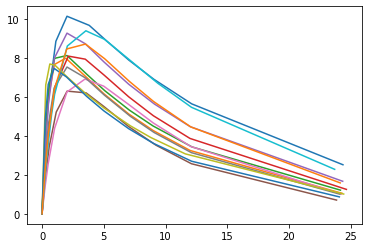

time-cwres


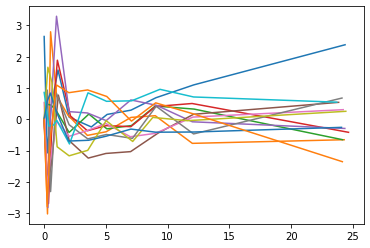

In [19]:
eval_result = model.evaluate()

print('time-pred')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    y_pred = eval_result['preds'][id]
    ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu').numpy())
plt.show()

print('time-cwres')
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
for id, time_data in eval_result['times'].items() :
    cwres_value = eval_result['cwress'][id]
    ax.plot(time_data.masked_select(eval_result['mdv_masks'][id]).to('cpu'), cwres_value.detach().to('cpu').numpy())
plt.show()

In [20]:
for k, v in eval_result.items():
    print(k)
    print(v)

total_loss
tensor(92.2152)
losses
{'1': 20.08148765563965, '2': 17.496047973632812, '3': -1.2924976348876953, '4': 9.288285255432129, '5': 20.158823013305664, '6': 4.124837875366211, '7': 1.3013362884521484, '8': 3.954768180847168, '9': 3.0549678802490234, '10': 4.816976547241211, '11': -2.398679733276367, '12': 11.62883186340332}
times
{'1': tensor([ 0.0000,  0.0000,  0.2500,  0.5700,  1.1200,  2.0200,  3.8200,  5.1000,
         7.0300,  9.0500, 12.1200, 24.3700]), '2': tensor([ 0.0000,  0.0000,  0.2700,  0.5200,  1.0000,  1.9200,  3.5000,  5.0200,
         7.0300,  9.0000, 12.0000, 24.3000]), '3': tensor([ 0.0000,  0.0000,  0.2700,  0.5800,  1.0200,  2.0200,  3.6200,  5.0800,
         7.0700,  9.0000, 12.1500, 24.1700]), '4': tensor([ 0.0000,  0.0000,  0.3500,  0.6000,  1.0700,  2.1300,  3.5000,  5.0200,
         7.0200,  9.0200, 11.9800, 24.6500]), '5': tensor([ 0.0000,  0.0000,  0.3000,  0.5200,  1.0000,  2.0200,  3.5000,  5.0200,
         7.0200,  9.1000, 12.0000, 24.3500]), '6': 

In [21]:
cov_result = model.descale().covariance_step()
print(cov_result)

id 1
id 2
id 3
id 4
id 5
id 6
id 7
id 8
id 9
id 10
id 11
id 12
{'cov': tensor([[ 6.9392e-03,  3.1273e-04, -1.3138e-04,  4.8972e-03,  6.5441e-04,
          1.8926e-04,  1.2730e-04,  2.5947e-04,  3.9445e-04, -8.6257e-04,
          5.1364e-03],
        [ 1.0498e-01,  9.0399e-01, -3.4956e-03,  4.3304e-02,  1.4227e-03,
          9.4701e-04, -2.5523e-03,  2.2652e-03,  3.3282e-03, -4.2399e-03,
          1.7445e-02],
        [-3.0066e-04, -1.6892e-03,  9.3383e-06, -1.0838e-04, -3.6671e-06,
         -4.9273e-06,  4.4248e-06, -1.0687e-05, -1.6498e-05,  2.2431e-05,
         -1.3585e-04],
        [ 2.7023e-03,  2.2475e-02, -6.7159e-05,  2.5080e-02,  3.1672e-03,
          2.2795e-04, -3.2697e-04, -2.1635e-04, -3.4284e-04, -1.5989e-04,
         -2.6314e-03],
        [ 8.2138e-05, -4.3604e-03,  1.0093e-05,  3.1639e-03,  6.3635e-04,
          6.7803e-05,  2.3457e-04, -1.6379e-05, -6.7520e-05, -4.7099e-05,
         -1.4677e-04],
        [ 3.1614e-05, -1.7716e-03,  1.8928e-06,  2.2918e-04,  6.7894e-05,


In [22]:
for (name, para) in model.named_parameters():
    print(name)
    print(para.detach().numpy())

pred_function_module.theta
[ 1.4895394  32.46419     0.08727226]
pred_function_module.etas.1
[-0.1040159  -0.1914239  -0.28256437]
pred_function_module.etas.2
[0.329498   0.05530924 0.04672762]
pred_function_module.etas.3
[ 0.41095507  0.04366204 -0.01186323]
pred_function_module.etas.4
[-0.34489095 -0.04238608  0.01662295]
pred_function_module.etas.5
[-0.03234923 -0.11045367 -0.09195249]
pred_function_module.etas.6
[-0.4706335   0.13954943  0.22850628]
pred_function_module.etas.7
[-0.8593021   0.00359319  0.144492  ]
pred_function_module.etas.8
[-0.06322124  0.0722046   0.07579691]
pred_function_module.etas.9
[ 1.3318719   0.17704976 -0.01259366]
pred_function_module.etas.10
[-0.7122013  -0.21455276 -0.14871462]
pred_function_module.etas.11
[0.8649927  0.17612009 0.0782083 ]
pred_function_module.etas.12
[-0.5001907  -0.13688345 -0.02357551]
pred_function_module.epss.1
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
pred_func

#Simulation

id 1


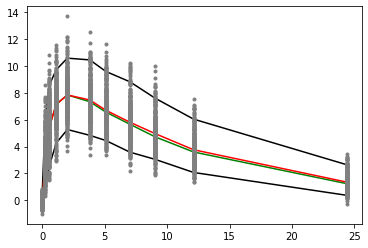

id 2


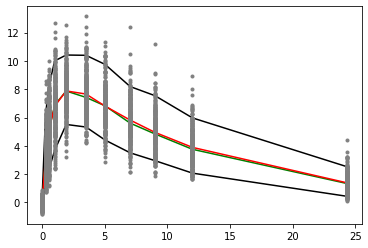

id 3


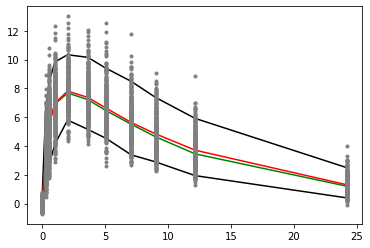

id 4


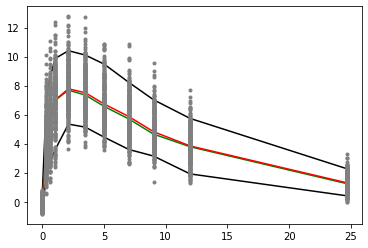

id 5


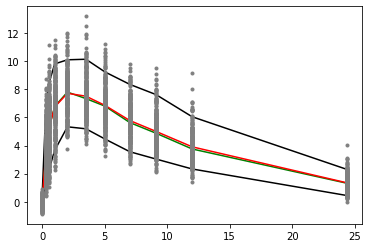

id 6


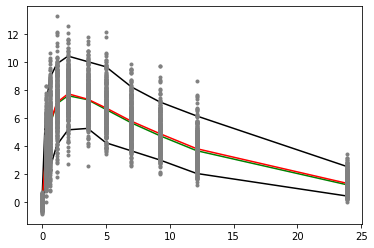

id 7


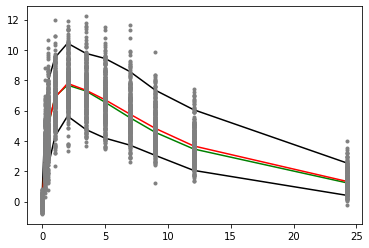

id 8


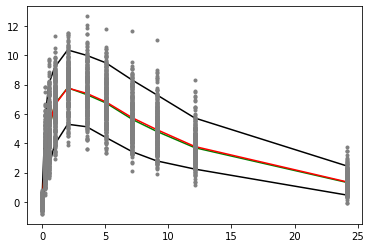

id 9


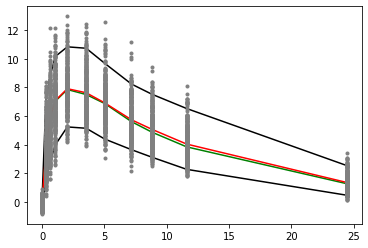

id 10


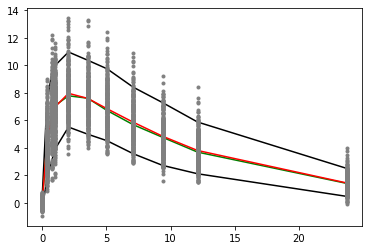

id 11


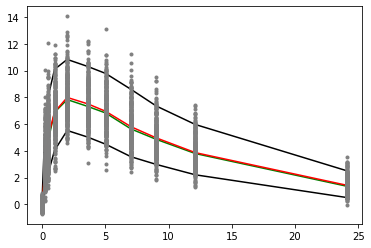

id 12


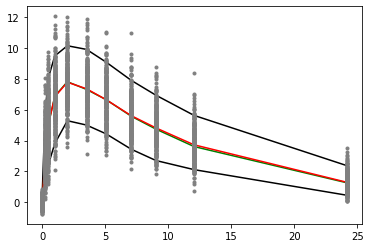

In [23]:
tc.manual_seed(42)
simulation_result = model.simulate(dataset, 300)

for id, time_data in simulation_result['times'].items() :
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    print('id', id)
    
    p95 = np.percentile(tc.stack(simulation_result['preds'][id]), 95, 0)
    p50 = np.percentile(tc.stack(simulation_result['preds'][id]), 50, 0)
    average = np.average(tc.stack(simulation_result['preds'][id]), 0)
    p5 = np.percentile(tc.stack(simulation_result['preds'][id]), 5, 0)
    
    ax.plot(time_data.to('cpu'), p95, color="black")
    ax.plot(time_data.to('cpu'), p50, color="green")
    ax.plot(time_data.to('cpu'), average, color="red")
    ax.plot(time_data.to('cpu'), p5, color="black")
    
    for y_pred in simulation_result['preds'][id] :
        ax.plot(time_data.to('cpu'), y_pred.detach().to('cpu'), marker='.', linestyle='', color='gray')
    plt.show()